In [1]:
import operator
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import rfpimp

from sklearn import feature_selection
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler, RobustScaler, Imputer, LabelEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

from IPython.core.pylabtools import figsize 
%matplotlib inline
sns.set()

In [2]:
class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]
    
def univariate_auc(dataset, variable_name):
    dataset = dataset[[variable_name, "TYPE"]].dropna(how="any").sort_values(by=variable_name, ascending=False)
    binary = np.where(dataset.TYPE == "Disease", 1, 0)
    sorted_variable = dataset[[variable_name]]
    fpr, tpr, _ = roc_curve(binary, sorted_variable)
    return auc(fpr, tpr)


def balanced_accuracy(dataset, variable_name):
    dataset = pd.concat([dataset[[variable_name]].astype('bool'), dataset[["TYPE"]]], axis=1).sort_values(by=variable_name, ascending=False).dropna()
    tp = dataset[(dataset.TYPE == "Disease") & (dataset[variable_name])].shape[0]
    p = dataset[dataset.TYPE == "Disease"].shape[0]
    tn = dataset[(dataset.TYPE == "Polymorphism") & (~dataset[variable_name])].shape[0]
    n = dataset[dataset.TYPE == "Polymorphism"].shape[0]
    return (tp/p + tn/n) / 2

In [3]:
RANDOM_STATE = 42

In [4]:
structural_dataset = pd.read_csv("../data/processed/structural/dataset.csv.gz", index_col="MUTANT")

In [5]:
structural_dataset.shape

(68508, 50)

In [6]:
structural_dataset.TYPE.value_counts(normalize=True)

Polymorphism    0.578808
Disease         0.421192
Name: TYPE, dtype: float64

In [7]:
len(structural_dataset.columns)

50

In [8]:
le = LabelEncoder()
X = structural_dataset[~structural_dataset.TYPE.isnull()].drop(['TYPE'], 1)
y = 1 - le.fit_transform(structural_dataset[~structural_dataset.TYPE.isnull()].TYPE)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

In [9]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{'Disease': 0, 'Polymorphism': 1}


In [10]:
pd.Series(y).value_counts(normalize=True)

0    0.578808
1    0.421192
dtype: float64

In [11]:
cat_vars = ['BINDING','ACT_SITE','SITE','LIPID','METAL','CARBOHYD','DNA_BIND','NP_BIND',
            'CA_BIND','DISULFID','SE_CYS','MOD_RES','PROPEP','SIGNALP','TRANSMEM','COMPBIAS',
            'REP','MOTIF','ZN_FING','REGIONS','PPI','RNABD','TF','LOC','MMBRBD','CHROM','POSTMODREC','POSTMODENZ']
cont_vars = X.columns.drop(cat_vars, 1).tolist()

impute = ('union', 
          FeatureUnion(
              transformer_list=[
                  ('continuous', Pipeline([
                      ('selector', ItemSelector(key=cont_vars)),
                      ('imputer', Imputer(missing_values="NaN", strategy="median"))
                  ])),
                  ('categorical', Pipeline([
                      ('selector', ItemSelector(key=cat_vars)),
                      ('imputer', Imputer(missing_values="NaN", strategy="most_frequent"))
                      
                  ]))
              ]))
                  

# impute = ('imputer', Imputer(missing_values="NaN", strategy="median"))

scale = ('scaler', RobustScaler())

model_dict = {
    'lr':{'pipe':[impute, scale, ('lr', LogisticRegression())],
        'params':[{'lr__C' : [.001, .01, .1, 1, 10, 100, 1000], 'lr__class_weight':[None, 'balanced']}],
        'name':'LogisticRegression'
    },
    'rf':{'pipe':[impute, ('rf', RandomForestClassifier(random_state=RANDOM_STATE))],
        'params':[{'rf__max_depth':[3,5,7], 'rf__n_estimators':[10,50,100], 'rf__max_features':['sqrt', 0.2, 4]}],
        'name':'Random Forest'
    },
    'svc':{'pipe': [impute, scale, ('svc', SVC(kernel='rbf', probability=True))],
           'params':[{'svc__kernel': ['rbf'], 'svc__gamma': [1e-2, 1e-3, 1e-4],
                'svc__C': [0.001, 0.10, 0.1, 10, 100, 1000]}]
        
    },
}

In [12]:
structural_dataset.TYPE.value_counts()

Polymorphism    39653
Disease         28855
Name: TYPE, dtype: int64

In [13]:
for variable in cont_vars:
    print(variable, ":", univariate_auc(structural_dataset, variable))

CHARGE : 0.5040822528027855
VOLUME : 0.4797079504935439
HYDROPHOBICITY : 0.5163446599779881
GRANTHAM : 0.6349835109832178
POLARITY : 0.5157793098737286
EX : 0.3534400090396723
PAM250 : 0.3569869126735147
BLOSUM : 0.3494370908394165
JM : 0.3962779425755624
VB : 0.42094243688626265
TRANSITION : 0.46556569548800075
AROMATICITY_DIFF : 0.5915174000720065
AROMATICITY_LOG_RATIO : 0.5299995829180415
ISOELECTRIC_POINT_DIFF : 0.5585973270032559
ISOELECTRIC_POINT_LOG_RATIO : 0.5074789244071886
GRAVY_DIFF : 0.5488952641967197
GRAVY_LOG_RATIO : 0.4839302707180353
INSTABILITY_INDEX_DIFF : 0.4934976566450576
INSTABILITY_INDEX_LOG_RATIO : 0.48207907452983145
FLEXIBILITY_DIFF : 0.5417289835244022
FLEXIBILITY_LOG_RATIO : 0.4733978561635521


In [14]:
structural_dataset.shape

(68508, 50)

In [15]:
structural_dataset.BINDING.isnull().sum()

46887

In [16]:
for variable in cat_vars:
    print(variable, ":", balanced_accuracy(structural_dataset, variable))

BINDING : 0.46793041793161283
ACT_SITE : 0.46690497176155116
SITE : 0.4670860636136313
LIPID : 0.4663001166902466
METAL : 0.4680155115161367
CARBOHYD : 0.4661168455621272
DNA_BIND : 0.47303544393865266
NP_BIND : 0.4700756829313389
CA_BIND : 0.4663551146780543
DISULFID : 0.47009586668945025
SE_CYS : 0.4662953980572665
MOD_RES : 0.46701952817926495
PROPEP : 0.4643639035624163
SIGNALP : 0.46353346785705274
TRANSMEM : 0.4841472543330897
COMPBIAS : 0.45521246754951133
REP : 0.4713745974364346
MOTIF : 0.4675520572433544
ZN_FING : 0.46609234695107593
REGIONS : 0.4789272305470368
PPI : 0.4600623002012568
RNABD : 0.4699106535716139
TF : 0.46594796761927043
LOC : 0.46665548158082837
MMBRBD : 0.4675484105502428
CHROM : 0.4661440854201394
POSTMODREC : 0.4658160040867085
POSTMODENZ : 0.46944431646666174


In [17]:
folds = 3
skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=1001)
algorithm = 'rf'
model = Pipeline(model_dict[algorithm]['pipe'])
param_list = [model_dict[algorithm]['params']][0]
gs = GridSearchCV(model, param_list, cv=skf.split(X_train, y_train), n_jobs=2, 
                  scoring='roc_auc', verbose=2, refit=True)

In [18]:
gs.fit(X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=10 .....
[CV] rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=10 .....
[CV]  rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=10, total=   0.7s
[CV] rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=10 .....
[CV]  rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=10, total=   0.6s
[CV] rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=50 .....
[CV]  rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=10, total=   0.4s
[CV] rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=50 .....
[CV]  rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=50, total=   1.4s
[CV] rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=50 .....
[CV]  rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=50, total=   1.4s
[CV] rf__max_depth=3, rf__max_features=sqrt, rf__n_estimators=100 ....
[CV]  rf__max_depth=3, rf__max_featur

[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:   31.0s


[CV]  rf__max_depth=5, rf__max_features=sqrt, rf__n_estimators=100, total=   3.0s
[CV] rf__max_depth=5, rf__max_features=0.2, rf__n_estimators=50 ......
[CV]  rf__max_depth=5, rf__max_features=0.2, rf__n_estimators=10, total=   0.6s
[CV] rf__max_depth=5, rf__max_features=0.2, rf__n_estimators=50 ......
[CV]  rf__max_depth=5, rf__max_features=0.2, rf__n_estimators=50, total=   1.7s
[CV]  rf__max_depth=5, rf__max_features=0.2, rf__n_estimators=50, total=   1.8s
[CV] rf__max_depth=5, rf__max_features=0.2, rf__n_estimators=50 ......
[CV] rf__max_depth=5, rf__max_features=0.2, rf__n_estimators=100 .....
[CV]  rf__max_depth=5, rf__max_features=0.2, rf__n_estimators=50, total=   1.7s
[CV] rf__max_depth=5, rf__max_features=0.2, rf__n_estimators=100 .....
[CV]  rf__max_depth=5, rf__max_features=0.2, rf__n_estimators=100, total=   3.5s
[CV] rf__max_depth=5, rf__max_features=0.2, rf__n_estimators=100 .....
[CV]  rf__max_depth=5, rf__max_features=0.2, rf__n_estimators=100, total=   3.7s
[CV] rf__m

[Parallel(n_jobs=2)]: Done  81 out of  81 | elapsed:  1.3min finished


GridSearchCV(cv=<generator object _BaseKFold.split at 0x7fc1ffe54728>,
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('continuous', Pipeline(memory=None,
     steps=[('selector', ItemSelector(key=['CHARGE', 'VOLUME', 'HYDROPHOBICITY', 'GRANTHAM', 'POLARITY', 'EX', 'PAM250', 'BLOSUM', 'JM', 'VB', 'TRANSITION', 'AROMATICITY_DIFF', 'AROMATICITY_LOG_RATI...stimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=2,
       param_grid=[{'rf__max_depth': [3, 5, 7], 'rf__n_estimators': [10, 50, 100], 'rf__max_features': ['sqrt', 0.2, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=2)

In [19]:
gs.best_score_

0.7149790360704883

In [20]:
gs.best_params_

{'rf__max_depth': 7, 'rf__max_features': 0.2, 'rf__n_estimators': 100}

In [21]:
rf = gs.best_estimator_

In [22]:
rf.get_params

<bound method Pipeline.get_params of Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('continuous', Pipeline(memory=None,
     steps=[('selector', ItemSelector(key=['CHARGE', 'VOLUME', 'HYDROPHOBICITY', 'GRANTHAM', 'POLARITY', 'EX', 'PAM250', 'BLOSUM', 'JM', 'VB', 'TRANSITION', 'AROMATICITY_DIFF', 'AROMATICITY_LOG_RATI...timators=100, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False))])>

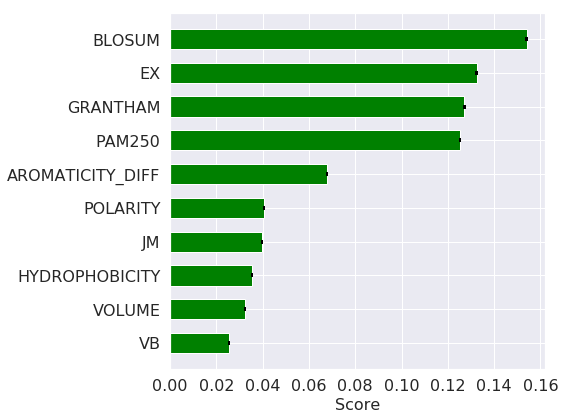

In [23]:
# cols = (cont_vars + cat_vars)
# ranking_size = 10
# forest = rf.steps[1][1]

# importances = [(cols[e], x) for e, x in enumerate(forest.feature_importances_)]
# importances.sort(key=operator.itemgetter(1), reverse=True)
# indices = np.argsort(forest.feature_importances_)[:ranking_size]
# importances = importances[:ranking_size][::-1]
# std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
# plt.figure(figsize=(8,6))
# plt.barh(np.arange(len(importances)), [y for x, y in importances], 0.6, color="green", align="center", 
#          xerr=std[indices], ecolor="black", error_kw={"capthick":2, "capsize":2})
# plt.yticks(range(len(importances)), [x for x, y in importances], rotation='horizontal', fontsize=16)
# plt.xlabel("Score",fontsize=16)
# plt.xticks(fontsize=14)
# plt.tight_layout()


cols = (cont_vars + cat_vars)
ranking_size = 10
forest = rf.steps[1][1]

importances = [(cols[e], x) for e, x in enumerate(forest.feature_importances_)]
importances.sort(key=operator.itemgetter(1), reverse=True)
indices = np.argsort(forest.feature_importances_)[:ranking_size]
importances = importances[:ranking_size][::-1]
std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
plt.figure(figsize=(8,6))
plt.barh(np.arange(len(importances)), [y for x, y in importances], 0.6, color="green", align="center", 
         xerr=std[indices], ecolor="black", error_kw={"capthick":2, "capsize":2})
plt.yticks(range(len(importances)), [x for x, y in importances], rotation='horizontal', fontsize=16)
plt.xlabel("Score",fontsize=16)
plt.xticks(fontsize=16)
plt.tight_layout()

# plt.savefig("/home/marlan/Desktop/importances_structural.pdf", bbox_inches='tight', pad_inches=0.1)


In [24]:
y_test

array([0, 0, 0, ..., 1, 1, 0])

In [25]:
features1 = ["EX", "PAM250", "BLOSUM", "JM", "GRANTHAM", "VB"] 
features2 = ["HYDROPHOBICITY", "POLARITY"]
features3 = ["CHARGE", "ISOELECTRIC_POINT_LOG_RATIO"]
features = X.drop(features1+features2+features3, axis=1).columns.tolist() + [features1] + [features2] + [features3]


In [26]:
%reload_ext autoreload
%autoreload 2
import rfpimp

In [27]:
I = rfpimp.importances(rf, X_test, y_test, n_samples=-1, features=features)

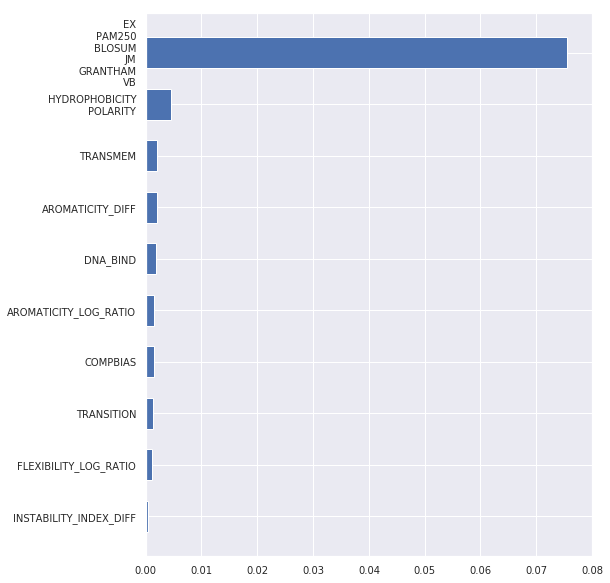

In [49]:
rfpimp.plot_importances(I.iloc[:10], label_fontsize=10, scalefig=(2,2), figsize=(8,10), tickstep=1, save="/home/marlan/Desktop/structural_importance_cluster.pdf")

In [15]:
for variable in cont_vars:
    print(variable, ":", univariate_auc(structural_dataset, variable))
print("------")
for variable in cat_vars:
    print(variable, ":", balanced_accuracy(structural_dataset, variable))

CHARGE : 0.4959177471972145
VOLUME : 0.520292049506456
HYDROPHOBICITY : 0.483655340022012
GRANTHAM : 0.36501648901678213
POLARITY : 0.48422069012627156
EX : 0.6465599909603277
PAM250 : 0.6430130873264853
BLOSUM : 0.6505629091605836
JM : 0.6037220574244376
VB : 0.5790575631137371
TRANSITION : 0.5344343045119992
AROMATICITY_DIFF : 0.4084825999279935
AROMATICITY_LOG_RATIO : 0.4700004170819586
ISOELECTRIC_POINT_DIFF : 0.44140267299674407
ISOELECTRIC_POINT_LOG_RATIO : 0.49252107559281133
GRAVY_DIFF : 0.45110473580328025
GRAVY_LOG_RATIO : 0.5160697292819646
INSTABILITY_INDEX_DIFF : 0.5065023433549424
INSTABILITY_INDEX_LOG_RATIO : 0.5179209254701685
FLEXIBILITY_DIFF : 0.45827101647559776
FLEXIBILITY_LOG_RATIO : 0.5266021438364478
------
BINDING : 0.46793041793161283
ACT_SITE : 0.46690497176155116
SITE : 0.4670860636136313
LIPID : 0.4663001166902466
METAL : 0.4680155115161367
CARBOHYD : 0.4661168455621272
DNA_BIND : 0.47303544393865266
NP_BIND : 0.4700756829313389
CA_BIND : 0.4663551146780543


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


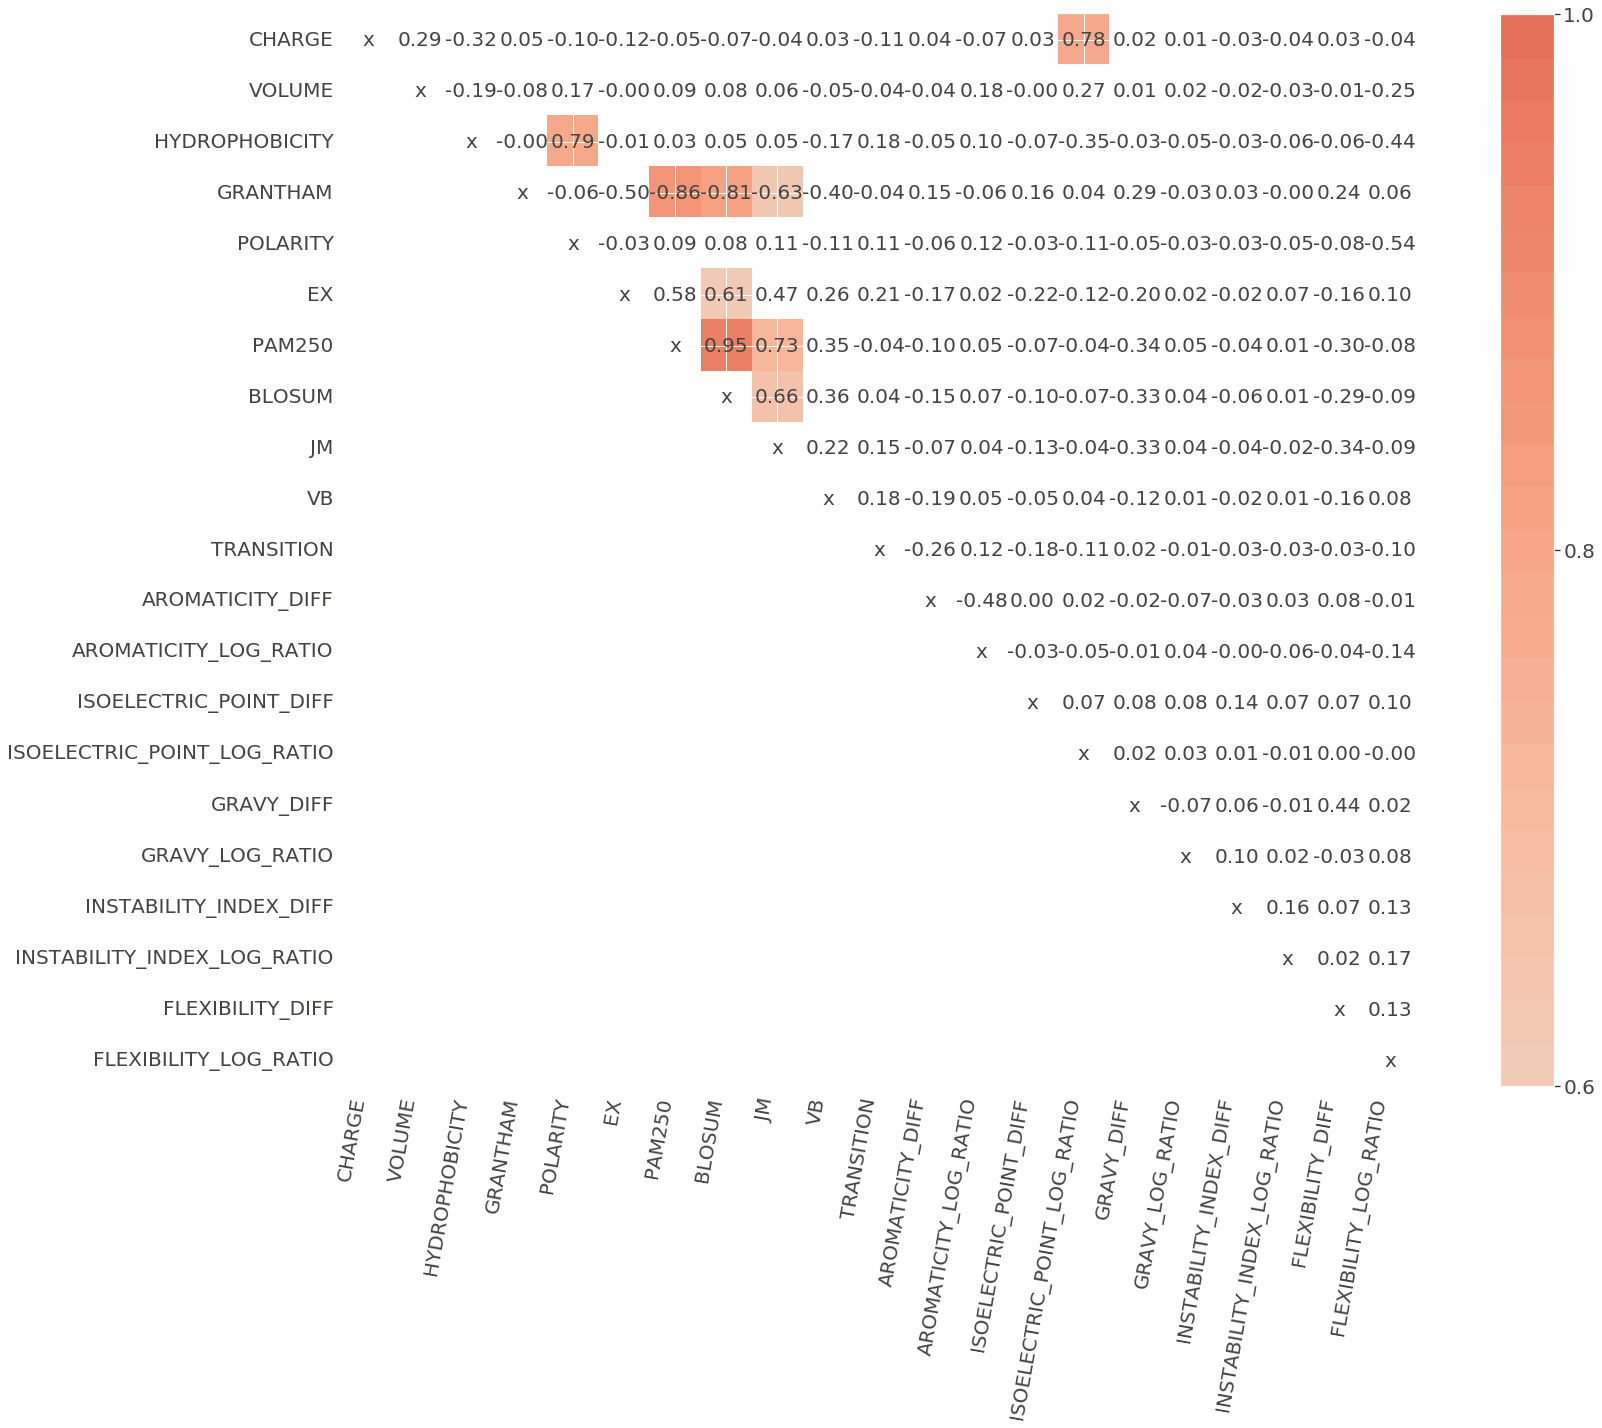

In [34]:
%load_ext autoreload
%autoreload 2
rfpimp.plot_corr_heatmap(X[cont_vars], figsize=(30,20), value_fontsize=20, label_fontsize=20)
plt.savefig("/home/marlan/Desktop/structural_corr.pdf", bbox_inches='tight', pad_inches=0.1)



In [50]:
fpr, tpr, _ = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

In [18]:
roc_auc

0.4988168040786071

In [24]:
roc_curve = pd.concat([pd.Series(fpr,name="fpr"), pd.Series(tpr, name="tpr")], axis=1)
roc_curve.to_csv("../results/structural/auc_rf.csv", index=False)

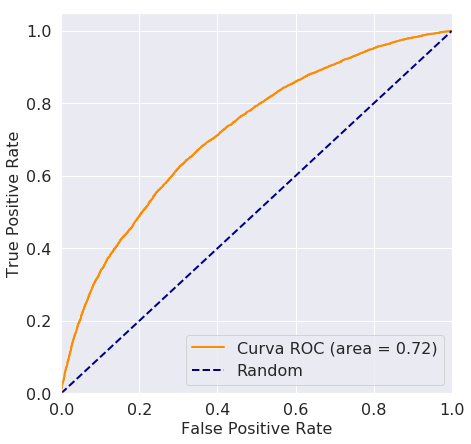

In [53]:
figsize(7,7)

lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='Curva ROC (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# plt.title('AUC Curve')
plt.legend(loc="lower right", prop={'size': 16})

# plt.savefig("/home/marlan/Desktop/auc_structural.pdf", bbox_inches='tight', pad_inches=0.1)

In [15]:
print(classification_report(le.inverse_transform(y_test), le.inverse_transform(rf.predict(X_test))))

/home/marlan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


              precision    recall  f1-score   support

     Disease       0.65      0.48      0.55      9522
Polymorphism       0.68      0.81      0.74     13086

 avg / total       0.67      0.67      0.66     22608



/home/marlan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [54]:
### Confidence Interval for AUC

import numpy as np
from scipy.stats import sem
from sklearn.metrics import roc_auc_score

y_pred = rf.predict_proba(X_test)[:, 1]
y_true = y_test

print("Original ROC area: {:0.3f}".format(roc_auc_score(y_true, y_pred)))

n_bootstraps = 10000
rng_seed = 42  # control reproducibility
bootstrapped_scores = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
    if len(np.unique(y_true[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = roc_auc_score(y_true[indices], y_pred[indices])
    bootstrapped_scores.append(score)
    print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))

Original ROC area: 0.720
Bootstrap #1 ROC area: 0.718
Bootstrap #2 ROC area: 0.718
Bootstrap #3 ROC area: 0.721
Bootstrap #4 ROC area: 0.719
Bootstrap #5 ROC area: 0.719
Bootstrap #6 ROC area: 0.719
Bootstrap #7 ROC area: 0.722
Bootstrap #8 ROC area: 0.720
Bootstrap #9 ROC area: 0.723
Bootstrap #10 ROC area: 0.715
Bootstrap #11 ROC area: 0.722
Bootstrap #12 ROC area: 0.725
Bootstrap #13 ROC area: 0.718
Bootstrap #14 ROC area: 0.715
Bootstrap #15 ROC area: 0.720
Bootstrap #16 ROC area: 0.709
Bootstrap #17 ROC area: 0.722
Bootstrap #18 ROC area: 0.718
Bootstrap #19 ROC area: 0.720
Bootstrap #20 ROC area: 0.719
Bootstrap #21 ROC area: 0.718
Bootstrap #22 ROC area: 0.719
Bootstrap #23 ROC area: 0.724
Bootstrap #24 ROC area: 0.724
Bootstrap #25 ROC area: 0.720
Bootstrap #26 ROC area: 0.725
Bootstrap #27 ROC area: 0.719
Bootstrap #28 ROC area: 0.722
Bootstrap #29 ROC area: 0.717
Bootstrap #30 ROC area: 0.717
Bootstrap #31 ROC area: 0.718


/home/marlan/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:19: DeprecationWarning: This function is deprecated. Please call randint(0, 22607 + 1) instead


Bootstrap #32 ROC area: 0.719
Bootstrap #33 ROC area: 0.717
Bootstrap #34 ROC area: 0.719
Bootstrap #35 ROC area: 0.725
Bootstrap #36 ROC area: 0.715
Bootstrap #37 ROC area: 0.716
Bootstrap #38 ROC area: 0.721
Bootstrap #39 ROC area: 0.719
Bootstrap #40 ROC area: 0.722
Bootstrap #41 ROC area: 0.717
Bootstrap #42 ROC area: 0.719
Bootstrap #43 ROC area: 0.724
Bootstrap #44 ROC area: 0.714
Bootstrap #45 ROC area: 0.721
Bootstrap #46 ROC area: 0.716
Bootstrap #47 ROC area: 0.721
Bootstrap #48 ROC area: 0.725
Bootstrap #49 ROC area: 0.717
Bootstrap #50 ROC area: 0.722
Bootstrap #51 ROC area: 0.721
Bootstrap #52 ROC area: 0.719
Bootstrap #53 ROC area: 0.716
Bootstrap #54 ROC area: 0.720
Bootstrap #55 ROC area: 0.721
Bootstrap #56 ROC area: 0.719
Bootstrap #57 ROC area: 0.714
Bootstrap #58 ROC area: 0.718
Bootstrap #59 ROC area: 0.716
Bootstrap #60 ROC area: 0.716
Bootstrap #61 ROC area: 0.718
Bootstrap #62 ROC area: 0.720
Bootstrap #63 ROC area: 0.717
Bootstrap #64 ROC area: 0.715
Bootstrap 

Bootstrap #316 ROC area: 0.723
Bootstrap #317 ROC area: 0.719
Bootstrap #318 ROC area: 0.716
Bootstrap #319 ROC area: 0.715
Bootstrap #320 ROC area: 0.726
Bootstrap #321 ROC area: 0.719
Bootstrap #322 ROC area: 0.721
Bootstrap #323 ROC area: 0.715
Bootstrap #324 ROC area: 0.722
Bootstrap #325 ROC area: 0.717
Bootstrap #326 ROC area: 0.720
Bootstrap #327 ROC area: 0.716
Bootstrap #328 ROC area: 0.715
Bootstrap #329 ROC area: 0.721
Bootstrap #330 ROC area: 0.720
Bootstrap #331 ROC area: 0.717
Bootstrap #332 ROC area: 0.722
Bootstrap #333 ROC area: 0.721
Bootstrap #334 ROC area: 0.716
Bootstrap #335 ROC area: 0.720
Bootstrap #336 ROC area: 0.721
Bootstrap #337 ROC area: 0.722
Bootstrap #338 ROC area: 0.727
Bootstrap #339 ROC area: 0.721
Bootstrap #340 ROC area: 0.723
Bootstrap #341 ROC area: 0.712
Bootstrap #342 ROC area: 0.717
Bootstrap #343 ROC area: 0.718
Bootstrap #344 ROC area: 0.722
Bootstrap #345 ROC area: 0.723
Bootstrap #346 ROC area: 0.718
Bootstrap #347 ROC area: 0.724
Bootstra

Bootstrap #606 ROC area: 0.720
Bootstrap #607 ROC area: 0.720
Bootstrap #608 ROC area: 0.714
Bootstrap #609 ROC area: 0.714
Bootstrap #610 ROC area: 0.723
Bootstrap #611 ROC area: 0.727
Bootstrap #612 ROC area: 0.724
Bootstrap #613 ROC area: 0.721
Bootstrap #614 ROC area: 0.719
Bootstrap #615 ROC area: 0.724
Bootstrap #616 ROC area: 0.720
Bootstrap #617 ROC area: 0.716
Bootstrap #618 ROC area: 0.724
Bootstrap #619 ROC area: 0.721
Bootstrap #620 ROC area: 0.727
Bootstrap #621 ROC area: 0.718
Bootstrap #622 ROC area: 0.717
Bootstrap #623 ROC area: 0.718
Bootstrap #624 ROC area: 0.721
Bootstrap #625 ROC area: 0.718
Bootstrap #626 ROC area: 0.716
Bootstrap #627 ROC area: 0.720
Bootstrap #628 ROC area: 0.720
Bootstrap #629 ROC area: 0.722
Bootstrap #630 ROC area: 0.721
Bootstrap #631 ROC area: 0.722
Bootstrap #632 ROC area: 0.719
Bootstrap #633 ROC area: 0.724
Bootstrap #634 ROC area: 0.714
Bootstrap #635 ROC area: 0.721
Bootstrap #636 ROC area: 0.717
Bootstrap #637 ROC area: 0.719
Bootstra

Bootstrap #893 ROC area: 0.723
Bootstrap #894 ROC area: 0.720
Bootstrap #895 ROC area: 0.720
Bootstrap #896 ROC area: 0.718
Bootstrap #897 ROC area: 0.711
Bootstrap #898 ROC area: 0.726
Bootstrap #899 ROC area: 0.717
Bootstrap #900 ROC area: 0.718
Bootstrap #901 ROC area: 0.722
Bootstrap #902 ROC area: 0.717
Bootstrap #903 ROC area: 0.722
Bootstrap #904 ROC area: 0.720
Bootstrap #905 ROC area: 0.717
Bootstrap #906 ROC area: 0.718
Bootstrap #907 ROC area: 0.724
Bootstrap #908 ROC area: 0.719
Bootstrap #909 ROC area: 0.725
Bootstrap #910 ROC area: 0.723
Bootstrap #911 ROC area: 0.715
Bootstrap #912 ROC area: 0.719
Bootstrap #913 ROC area: 0.722
Bootstrap #914 ROC area: 0.717
Bootstrap #915 ROC area: 0.720
Bootstrap #916 ROC area: 0.721
Bootstrap #917 ROC area: 0.725
Bootstrap #918 ROC area: 0.716
Bootstrap #919 ROC area: 0.723
Bootstrap #920 ROC area: 0.717
Bootstrap #921 ROC area: 0.721
Bootstrap #922 ROC area: 0.718
Bootstrap #923 ROC area: 0.722
Bootstrap #924 ROC area: 0.717
Bootstra

Bootstrap #1173 ROC area: 0.718
Bootstrap #1174 ROC area: 0.717
Bootstrap #1175 ROC area: 0.725
Bootstrap #1176 ROC area: 0.718
Bootstrap #1177 ROC area: 0.717
Bootstrap #1178 ROC area: 0.720
Bootstrap #1179 ROC area: 0.723
Bootstrap #1180 ROC area: 0.725
Bootstrap #1181 ROC area: 0.715
Bootstrap #1182 ROC area: 0.714
Bootstrap #1183 ROC area: 0.721
Bootstrap #1184 ROC area: 0.726
Bootstrap #1185 ROC area: 0.723
Bootstrap #1186 ROC area: 0.719
Bootstrap #1187 ROC area: 0.723
Bootstrap #1188 ROC area: 0.723
Bootstrap #1189 ROC area: 0.718
Bootstrap #1190 ROC area: 0.720
Bootstrap #1191 ROC area: 0.719
Bootstrap #1192 ROC area: 0.715
Bootstrap #1193 ROC area: 0.723
Bootstrap #1194 ROC area: 0.707
Bootstrap #1195 ROC area: 0.716
Bootstrap #1196 ROC area: 0.722
Bootstrap #1197 ROC area: 0.719
Bootstrap #1198 ROC area: 0.722
Bootstrap #1199 ROC area: 0.723
Bootstrap #1200 ROC area: 0.720
Bootstrap #1201 ROC area: 0.722
Bootstrap #1202 ROC area: 0.725
Bootstrap #1203 ROC area: 0.715
Bootstra

Bootstrap #1437 ROC area: 0.722
Bootstrap #1438 ROC area: 0.721
Bootstrap #1439 ROC area: 0.721
Bootstrap #1440 ROC area: 0.724
Bootstrap #1441 ROC area: 0.725
Bootstrap #1442 ROC area: 0.719
Bootstrap #1443 ROC area: 0.722
Bootstrap #1444 ROC area: 0.722
Bootstrap #1445 ROC area: 0.723
Bootstrap #1446 ROC area: 0.715
Bootstrap #1447 ROC area: 0.717
Bootstrap #1448 ROC area: 0.721
Bootstrap #1449 ROC area: 0.723
Bootstrap #1450 ROC area: 0.721
Bootstrap #1451 ROC area: 0.724
Bootstrap #1452 ROC area: 0.714
Bootstrap #1453 ROC area: 0.719
Bootstrap #1454 ROC area: 0.725
Bootstrap #1455 ROC area: 0.725
Bootstrap #1456 ROC area: 0.718
Bootstrap #1457 ROC area: 0.718
Bootstrap #1458 ROC area: 0.717
Bootstrap #1459 ROC area: 0.717
Bootstrap #1460 ROC area: 0.720
Bootstrap #1461 ROC area: 0.716
Bootstrap #1462 ROC area: 0.727
Bootstrap #1463 ROC area: 0.724
Bootstrap #1464 ROC area: 0.719
Bootstrap #1465 ROC area: 0.720
Bootstrap #1466 ROC area: 0.721
Bootstrap #1467 ROC area: 0.723
Bootstra

Bootstrap #1717 ROC area: 0.717
Bootstrap #1718 ROC area: 0.722
Bootstrap #1719 ROC area: 0.724
Bootstrap #1720 ROC area: 0.719
Bootstrap #1721 ROC area: 0.727
Bootstrap #1722 ROC area: 0.715
Bootstrap #1723 ROC area: 0.726
Bootstrap #1724 ROC area: 0.721
Bootstrap #1725 ROC area: 0.722
Bootstrap #1726 ROC area: 0.721
Bootstrap #1727 ROC area: 0.722
Bootstrap #1728 ROC area: 0.718
Bootstrap #1729 ROC area: 0.715
Bootstrap #1730 ROC area: 0.716
Bootstrap #1731 ROC area: 0.719
Bootstrap #1732 ROC area: 0.722
Bootstrap #1733 ROC area: 0.719
Bootstrap #1734 ROC area: 0.722
Bootstrap #1735 ROC area: 0.724
Bootstrap #1736 ROC area: 0.712
Bootstrap #1737 ROC area: 0.724
Bootstrap #1738 ROC area: 0.721
Bootstrap #1739 ROC area: 0.721
Bootstrap #1740 ROC area: 0.724
Bootstrap #1741 ROC area: 0.721
Bootstrap #1742 ROC area: 0.726
Bootstrap #1743 ROC area: 0.722
Bootstrap #1744 ROC area: 0.724
Bootstrap #1745 ROC area: 0.716
Bootstrap #1746 ROC area: 0.720
Bootstrap #1747 ROC area: 0.720
Bootstra

Bootstrap #1992 ROC area: 0.718
Bootstrap #1993 ROC area: 0.718
Bootstrap #1994 ROC area: 0.717
Bootstrap #1995 ROC area: 0.719
Bootstrap #1996 ROC area: 0.712
Bootstrap #1997 ROC area: 0.714
Bootstrap #1998 ROC area: 0.716
Bootstrap #1999 ROC area: 0.715
Bootstrap #2000 ROC area: 0.714
Bootstrap #2001 ROC area: 0.723
Bootstrap #2002 ROC area: 0.715
Bootstrap #2003 ROC area: 0.721
Bootstrap #2004 ROC area: 0.723
Bootstrap #2005 ROC area: 0.712
Bootstrap #2006 ROC area: 0.713
Bootstrap #2007 ROC area: 0.722
Bootstrap #2008 ROC area: 0.722
Bootstrap #2009 ROC area: 0.716
Bootstrap #2010 ROC area: 0.718
Bootstrap #2011 ROC area: 0.717
Bootstrap #2012 ROC area: 0.724
Bootstrap #2013 ROC area: 0.722
Bootstrap #2014 ROC area: 0.720
Bootstrap #2015 ROC area: 0.717
Bootstrap #2016 ROC area: 0.721
Bootstrap #2017 ROC area: 0.720
Bootstrap #2018 ROC area: 0.725
Bootstrap #2019 ROC area: 0.715
Bootstrap #2020 ROC area: 0.715
Bootstrap #2021 ROC area: 0.722
Bootstrap #2022 ROC area: 0.719
Bootstra

Bootstrap #2275 ROC area: 0.722
Bootstrap #2276 ROC area: 0.723
Bootstrap #2277 ROC area: 0.728
Bootstrap #2278 ROC area: 0.717
Bootstrap #2279 ROC area: 0.725
Bootstrap #2280 ROC area: 0.726
Bootstrap #2281 ROC area: 0.720
Bootstrap #2282 ROC area: 0.724
Bootstrap #2283 ROC area: 0.715
Bootstrap #2284 ROC area: 0.719
Bootstrap #2285 ROC area: 0.718
Bootstrap #2286 ROC area: 0.715
Bootstrap #2287 ROC area: 0.726
Bootstrap #2288 ROC area: 0.720
Bootstrap #2289 ROC area: 0.717
Bootstrap #2290 ROC area: 0.723
Bootstrap #2291 ROC area: 0.720
Bootstrap #2292 ROC area: 0.719
Bootstrap #2293 ROC area: 0.728
Bootstrap #2294 ROC area: 0.714
Bootstrap #2295 ROC area: 0.716
Bootstrap #2296 ROC area: 0.721
Bootstrap #2297 ROC area: 0.722
Bootstrap #2298 ROC area: 0.716
Bootstrap #2299 ROC area: 0.722
Bootstrap #2300 ROC area: 0.715
Bootstrap #2301 ROC area: 0.718
Bootstrap #2302 ROC area: 0.714
Bootstrap #2303 ROC area: 0.723
Bootstrap #2304 ROC area: 0.715
Bootstrap #2305 ROC area: 0.716
Bootstra

Bootstrap #2555 ROC area: 0.716
Bootstrap #2556 ROC area: 0.723
Bootstrap #2557 ROC area: 0.718
Bootstrap #2558 ROC area: 0.718
Bootstrap #2559 ROC area: 0.726
Bootstrap #2560 ROC area: 0.726
Bootstrap #2561 ROC area: 0.725
Bootstrap #2562 ROC area: 0.723
Bootstrap #2563 ROC area: 0.720
Bootstrap #2564 ROC area: 0.714
Bootstrap #2565 ROC area: 0.716
Bootstrap #2566 ROC area: 0.725
Bootstrap #2567 ROC area: 0.718
Bootstrap #2568 ROC area: 0.722
Bootstrap #2569 ROC area: 0.718
Bootstrap #2570 ROC area: 0.723
Bootstrap #2571 ROC area: 0.714
Bootstrap #2572 ROC area: 0.725
Bootstrap #2573 ROC area: 0.718
Bootstrap #2574 ROC area: 0.726
Bootstrap #2575 ROC area: 0.719
Bootstrap #2576 ROC area: 0.717
Bootstrap #2577 ROC area: 0.724
Bootstrap #2578 ROC area: 0.717
Bootstrap #2579 ROC area: 0.716
Bootstrap #2580 ROC area: 0.724
Bootstrap #2581 ROC area: 0.725
Bootstrap #2582 ROC area: 0.722
Bootstrap #2583 ROC area: 0.717
Bootstrap #2584 ROC area: 0.713
Bootstrap #2585 ROC area: 0.717
Bootstra

Bootstrap #2831 ROC area: 0.718
Bootstrap #2832 ROC area: 0.717
Bootstrap #2833 ROC area: 0.723
Bootstrap #2834 ROC area: 0.719
Bootstrap #2835 ROC area: 0.723
Bootstrap #2836 ROC area: 0.721
Bootstrap #2837 ROC area: 0.725
Bootstrap #2838 ROC area: 0.719
Bootstrap #2839 ROC area: 0.722
Bootstrap #2840 ROC area: 0.716
Bootstrap #2841 ROC area: 0.719
Bootstrap #2842 ROC area: 0.719
Bootstrap #2843 ROC area: 0.724
Bootstrap #2844 ROC area: 0.716
Bootstrap #2845 ROC area: 0.722
Bootstrap #2846 ROC area: 0.725
Bootstrap #2847 ROC area: 0.717
Bootstrap #2848 ROC area: 0.711
Bootstrap #2849 ROC area: 0.722
Bootstrap #2850 ROC area: 0.722
Bootstrap #2851 ROC area: 0.719
Bootstrap #2852 ROC area: 0.720
Bootstrap #2853 ROC area: 0.723
Bootstrap #2854 ROC area: 0.713
Bootstrap #2855 ROC area: 0.718
Bootstrap #2856 ROC area: 0.721
Bootstrap #2857 ROC area: 0.720
Bootstrap #2858 ROC area: 0.716
Bootstrap #2859 ROC area: 0.718
Bootstrap #2860 ROC area: 0.724
Bootstrap #2861 ROC area: 0.716
Bootstra

Bootstrap #3103 ROC area: 0.713
Bootstrap #3104 ROC area: 0.717
Bootstrap #3105 ROC area: 0.720
Bootstrap #3106 ROC area: 0.717
Bootstrap #3107 ROC area: 0.722
Bootstrap #3108 ROC area: 0.718
Bootstrap #3109 ROC area: 0.716
Bootstrap #3110 ROC area: 0.719
Bootstrap #3111 ROC area: 0.721
Bootstrap #3112 ROC area: 0.715
Bootstrap #3113 ROC area: 0.727
Bootstrap #3114 ROC area: 0.720
Bootstrap #3115 ROC area: 0.721
Bootstrap #3116 ROC area: 0.719
Bootstrap #3117 ROC area: 0.722
Bootstrap #3118 ROC area: 0.720
Bootstrap #3119 ROC area: 0.719
Bootstrap #3120 ROC area: 0.719
Bootstrap #3121 ROC area: 0.718
Bootstrap #3122 ROC area: 0.722
Bootstrap #3123 ROC area: 0.720
Bootstrap #3124 ROC area: 0.722
Bootstrap #3125 ROC area: 0.719
Bootstrap #3126 ROC area: 0.719
Bootstrap #3127 ROC area: 0.719
Bootstrap #3128 ROC area: 0.720
Bootstrap #3129 ROC area: 0.719
Bootstrap #3130 ROC area: 0.720
Bootstrap #3131 ROC area: 0.722
Bootstrap #3132 ROC area: 0.718
Bootstrap #3133 ROC area: 0.719
Bootstra

Bootstrap #3384 ROC area: 0.718
Bootstrap #3385 ROC area: 0.723
Bootstrap #3386 ROC area: 0.723
Bootstrap #3387 ROC area: 0.719
Bootstrap #3388 ROC area: 0.724
Bootstrap #3389 ROC area: 0.720
Bootstrap #3390 ROC area: 0.716
Bootstrap #3391 ROC area: 0.721
Bootstrap #3392 ROC area: 0.719
Bootstrap #3393 ROC area: 0.721
Bootstrap #3394 ROC area: 0.726
Bootstrap #3395 ROC area: 0.723
Bootstrap #3396 ROC area: 0.721
Bootstrap #3397 ROC area: 0.721
Bootstrap #3398 ROC area: 0.714
Bootstrap #3399 ROC area: 0.718
Bootstrap #3400 ROC area: 0.716
Bootstrap #3401 ROC area: 0.720
Bootstrap #3402 ROC area: 0.723
Bootstrap #3403 ROC area: 0.722
Bootstrap #3404 ROC area: 0.720
Bootstrap #3405 ROC area: 0.725
Bootstrap #3406 ROC area: 0.716
Bootstrap #3407 ROC area: 0.726
Bootstrap #3408 ROC area: 0.719
Bootstrap #3409 ROC area: 0.716
Bootstrap #3410 ROC area: 0.720
Bootstrap #3411 ROC area: 0.716
Bootstrap #3412 ROC area: 0.722
Bootstrap #3413 ROC area: 0.722
Bootstrap #3414 ROC area: 0.717
Bootstra

Bootstrap #3663 ROC area: 0.718
Bootstrap #3664 ROC area: 0.722
Bootstrap #3665 ROC area: 0.718
Bootstrap #3666 ROC area: 0.718
Bootstrap #3667 ROC area: 0.721
Bootstrap #3668 ROC area: 0.719
Bootstrap #3669 ROC area: 0.715
Bootstrap #3670 ROC area: 0.719
Bootstrap #3671 ROC area: 0.722
Bootstrap #3672 ROC area: 0.722
Bootstrap #3673 ROC area: 0.725
Bootstrap #3674 ROC area: 0.724
Bootstrap #3675 ROC area: 0.719
Bootstrap #3676 ROC area: 0.717
Bootstrap #3677 ROC area: 0.716
Bootstrap #3678 ROC area: 0.718
Bootstrap #3679 ROC area: 0.715
Bootstrap #3680 ROC area: 0.713
Bootstrap #3681 ROC area: 0.719
Bootstrap #3682 ROC area: 0.724
Bootstrap #3683 ROC area: 0.716
Bootstrap #3684 ROC area: 0.718
Bootstrap #3685 ROC area: 0.714
Bootstrap #3686 ROC area: 0.710
Bootstrap #3687 ROC area: 0.717
Bootstrap #3688 ROC area: 0.718
Bootstrap #3689 ROC area: 0.722
Bootstrap #3690 ROC area: 0.721
Bootstrap #3691 ROC area: 0.715
Bootstrap #3692 ROC area: 0.717
Bootstrap #3693 ROC area: 0.720
Bootstra

Bootstrap #3941 ROC area: 0.714
Bootstrap #3942 ROC area: 0.721
Bootstrap #3943 ROC area: 0.718
Bootstrap #3944 ROC area: 0.725
Bootstrap #3945 ROC area: 0.719
Bootstrap #3946 ROC area: 0.717
Bootstrap #3947 ROC area: 0.719
Bootstrap #3948 ROC area: 0.720
Bootstrap #3949 ROC area: 0.719
Bootstrap #3950 ROC area: 0.720
Bootstrap #3951 ROC area: 0.723
Bootstrap #3952 ROC area: 0.720
Bootstrap #3953 ROC area: 0.727
Bootstrap #3954 ROC area: 0.719
Bootstrap #3955 ROC area: 0.723
Bootstrap #3956 ROC area: 0.721
Bootstrap #3957 ROC area: 0.722
Bootstrap #3958 ROC area: 0.719
Bootstrap #3959 ROC area: 0.721
Bootstrap #3960 ROC area: 0.720
Bootstrap #3961 ROC area: 0.727
Bootstrap #3962 ROC area: 0.719
Bootstrap #3963 ROC area: 0.723
Bootstrap #3964 ROC area: 0.723
Bootstrap #3965 ROC area: 0.720
Bootstrap #3966 ROC area: 0.723
Bootstrap #3967 ROC area: 0.722
Bootstrap #3968 ROC area: 0.718
Bootstrap #3969 ROC area: 0.719
Bootstrap #3970 ROC area: 0.717
Bootstrap #3971 ROC area: 0.715
Bootstra

Bootstrap #4213 ROC area: 0.721
Bootstrap #4214 ROC area: 0.720
Bootstrap #4215 ROC area: 0.724
Bootstrap #4216 ROC area: 0.720
Bootstrap #4217 ROC area: 0.720
Bootstrap #4218 ROC area: 0.724
Bootstrap #4219 ROC area: 0.719
Bootstrap #4220 ROC area: 0.720
Bootstrap #4221 ROC area: 0.727
Bootstrap #4222 ROC area: 0.719
Bootstrap #4223 ROC area: 0.723
Bootstrap #4224 ROC area: 0.726
Bootstrap #4225 ROC area: 0.715
Bootstrap #4226 ROC area: 0.718
Bootstrap #4227 ROC area: 0.723
Bootstrap #4228 ROC area: 0.719
Bootstrap #4229 ROC area: 0.726
Bootstrap #4230 ROC area: 0.720
Bootstrap #4231 ROC area: 0.726
Bootstrap #4232 ROC area: 0.719
Bootstrap #4233 ROC area: 0.724
Bootstrap #4234 ROC area: 0.715
Bootstrap #4235 ROC area: 0.725
Bootstrap #4236 ROC area: 0.715
Bootstrap #4237 ROC area: 0.720
Bootstrap #4238 ROC area: 0.716
Bootstrap #4239 ROC area: 0.724
Bootstrap #4240 ROC area: 0.720
Bootstrap #4241 ROC area: 0.722
Bootstrap #4242 ROC area: 0.721
Bootstrap #4243 ROC area: 0.722
Bootstra

Bootstrap #4489 ROC area: 0.727
Bootstrap #4490 ROC area: 0.718
Bootstrap #4491 ROC area: 0.720
Bootstrap #4492 ROC area: 0.724
Bootstrap #4493 ROC area: 0.726
Bootstrap #4494 ROC area: 0.717
Bootstrap #4495 ROC area: 0.715
Bootstrap #4496 ROC area: 0.723
Bootstrap #4497 ROC area: 0.724
Bootstrap #4498 ROC area: 0.721
Bootstrap #4499 ROC area: 0.725
Bootstrap #4500 ROC area: 0.716
Bootstrap #4501 ROC area: 0.719
Bootstrap #4502 ROC area: 0.726
Bootstrap #4503 ROC area: 0.720
Bootstrap #4504 ROC area: 0.718
Bootstrap #4505 ROC area: 0.716
Bootstrap #4506 ROC area: 0.719
Bootstrap #4507 ROC area: 0.711
Bootstrap #4508 ROC area: 0.719
Bootstrap #4509 ROC area: 0.721
Bootstrap #4510 ROC area: 0.717
Bootstrap #4511 ROC area: 0.717
Bootstrap #4512 ROC area: 0.722
Bootstrap #4513 ROC area: 0.719
Bootstrap #4514 ROC area: 0.720
Bootstrap #4515 ROC area: 0.716
Bootstrap #4516 ROC area: 0.716
Bootstrap #4517 ROC area: 0.726
Bootstrap #4518 ROC area: 0.711
Bootstrap #4519 ROC area: 0.715
Bootstra

Bootstrap #4768 ROC area: 0.717
Bootstrap #4769 ROC area: 0.719
Bootstrap #4770 ROC area: 0.716
Bootstrap #4771 ROC area: 0.721
Bootstrap #4772 ROC area: 0.715
Bootstrap #4773 ROC area: 0.721
Bootstrap #4774 ROC area: 0.718
Bootstrap #4775 ROC area: 0.721
Bootstrap #4776 ROC area: 0.724
Bootstrap #4777 ROC area: 0.723
Bootstrap #4778 ROC area: 0.717
Bootstrap #4779 ROC area: 0.726
Bootstrap #4780 ROC area: 0.724
Bootstrap #4781 ROC area: 0.724
Bootstrap #4782 ROC area: 0.719
Bootstrap #4783 ROC area: 0.716
Bootstrap #4784 ROC area: 0.722
Bootstrap #4785 ROC area: 0.725
Bootstrap #4786 ROC area: 0.722
Bootstrap #4787 ROC area: 0.723
Bootstrap #4788 ROC area: 0.722
Bootstrap #4789 ROC area: 0.723
Bootstrap #4790 ROC area: 0.728
Bootstrap #4791 ROC area: 0.727
Bootstrap #4792 ROC area: 0.717
Bootstrap #4793 ROC area: 0.719
Bootstrap #4794 ROC area: 0.724
Bootstrap #4795 ROC area: 0.712
Bootstrap #4796 ROC area: 0.714
Bootstrap #4797 ROC area: 0.719
Bootstrap #4798 ROC area: 0.720
Bootstra

Bootstrap #5051 ROC area: 0.719
Bootstrap #5052 ROC area: 0.723
Bootstrap #5053 ROC area: 0.719
Bootstrap #5054 ROC area: 0.717
Bootstrap #5055 ROC area: 0.718
Bootstrap #5056 ROC area: 0.717
Bootstrap #5057 ROC area: 0.720
Bootstrap #5058 ROC area: 0.725
Bootstrap #5059 ROC area: 0.721
Bootstrap #5060 ROC area: 0.721
Bootstrap #5061 ROC area: 0.719
Bootstrap #5062 ROC area: 0.723
Bootstrap #5063 ROC area: 0.723
Bootstrap #5064 ROC area: 0.722
Bootstrap #5065 ROC area: 0.721
Bootstrap #5066 ROC area: 0.725
Bootstrap #5067 ROC area: 0.717
Bootstrap #5068 ROC area: 0.722
Bootstrap #5069 ROC area: 0.714
Bootstrap #5070 ROC area: 0.720
Bootstrap #5071 ROC area: 0.721
Bootstrap #5072 ROC area: 0.722
Bootstrap #5073 ROC area: 0.724
Bootstrap #5074 ROC area: 0.716
Bootstrap #5075 ROC area: 0.725
Bootstrap #5076 ROC area: 0.720
Bootstrap #5077 ROC area: 0.719
Bootstrap #5078 ROC area: 0.721
Bootstrap #5079 ROC area: 0.715
Bootstrap #5080 ROC area: 0.716
Bootstrap #5081 ROC area: 0.722
Bootstra

Bootstrap #5325 ROC area: 0.724
Bootstrap #5326 ROC area: 0.719
Bootstrap #5327 ROC area: 0.721
Bootstrap #5328 ROC area: 0.716
Bootstrap #5329 ROC area: 0.720
Bootstrap #5330 ROC area: 0.723
Bootstrap #5331 ROC area: 0.721
Bootstrap #5332 ROC area: 0.717
Bootstrap #5333 ROC area: 0.724
Bootstrap #5334 ROC area: 0.724
Bootstrap #5335 ROC area: 0.716
Bootstrap #5336 ROC area: 0.722
Bootstrap #5337 ROC area: 0.722
Bootstrap #5338 ROC area: 0.723
Bootstrap #5339 ROC area: 0.716
Bootstrap #5340 ROC area: 0.721
Bootstrap #5341 ROC area: 0.723
Bootstrap #5342 ROC area: 0.725
Bootstrap #5343 ROC area: 0.720
Bootstrap #5344 ROC area: 0.716
Bootstrap #5345 ROC area: 0.724
Bootstrap #5346 ROC area: 0.713
Bootstrap #5347 ROC area: 0.721
Bootstrap #5348 ROC area: 0.719
Bootstrap #5349 ROC area: 0.720
Bootstrap #5350 ROC area: 0.716
Bootstrap #5351 ROC area: 0.724
Bootstrap #5352 ROC area: 0.723
Bootstrap #5353 ROC area: 0.720
Bootstrap #5354 ROC area: 0.715
Bootstrap #5355 ROC area: 0.720
Bootstra

Bootstrap #5600 ROC area: 0.719
Bootstrap #5601 ROC area: 0.723
Bootstrap #5602 ROC area: 0.721
Bootstrap #5603 ROC area: 0.720
Bootstrap #5604 ROC area: 0.718
Bootstrap #5605 ROC area: 0.722
Bootstrap #5606 ROC area: 0.717
Bootstrap #5607 ROC area: 0.715
Bootstrap #5608 ROC area: 0.716
Bootstrap #5609 ROC area: 0.716
Bootstrap #5610 ROC area: 0.718
Bootstrap #5611 ROC area: 0.722
Bootstrap #5612 ROC area: 0.720
Bootstrap #5613 ROC area: 0.722
Bootstrap #5614 ROC area: 0.721
Bootstrap #5615 ROC area: 0.723
Bootstrap #5616 ROC area: 0.714
Bootstrap #5617 ROC area: 0.714
Bootstrap #5618 ROC area: 0.717
Bootstrap #5619 ROC area: 0.717
Bootstrap #5620 ROC area: 0.717
Bootstrap #5621 ROC area: 0.725
Bootstrap #5622 ROC area: 0.723
Bootstrap #5623 ROC area: 0.718
Bootstrap #5624 ROC area: 0.718
Bootstrap #5625 ROC area: 0.717
Bootstrap #5626 ROC area: 0.719
Bootstrap #5627 ROC area: 0.717
Bootstrap #5628 ROC area: 0.715
Bootstrap #5629 ROC area: 0.726
Bootstrap #5630 ROC area: 0.720
Bootstra

Bootstrap #5877 ROC area: 0.710
Bootstrap #5878 ROC area: 0.717
Bootstrap #5879 ROC area: 0.719
Bootstrap #5880 ROC area: 0.714
Bootstrap #5881 ROC area: 0.722
Bootstrap #5882 ROC area: 0.720
Bootstrap #5883 ROC area: 0.720
Bootstrap #5884 ROC area: 0.726
Bootstrap #5885 ROC area: 0.716
Bootstrap #5886 ROC area: 0.721
Bootstrap #5887 ROC area: 0.720
Bootstrap #5888 ROC area: 0.719
Bootstrap #5889 ROC area: 0.715
Bootstrap #5890 ROC area: 0.720
Bootstrap #5891 ROC area: 0.718
Bootstrap #5892 ROC area: 0.723
Bootstrap #5893 ROC area: 0.721
Bootstrap #5894 ROC area: 0.725
Bootstrap #5895 ROC area: 0.722
Bootstrap #5896 ROC area: 0.718
Bootstrap #5897 ROC area: 0.721
Bootstrap #5898 ROC area: 0.713
Bootstrap #5899 ROC area: 0.726
Bootstrap #5900 ROC area: 0.717
Bootstrap #5901 ROC area: 0.722
Bootstrap #5902 ROC area: 0.721
Bootstrap #5903 ROC area: 0.722
Bootstrap #5904 ROC area: 0.719
Bootstrap #5905 ROC area: 0.721
Bootstrap #5906 ROC area: 0.716
Bootstrap #5907 ROC area: 0.717
Bootstra

Bootstrap #6147 ROC area: 0.719
Bootstrap #6148 ROC area: 0.718
Bootstrap #6149 ROC area: 0.721
Bootstrap #6150 ROC area: 0.721
Bootstrap #6151 ROC area: 0.718
Bootstrap #6152 ROC area: 0.721
Bootstrap #6153 ROC area: 0.718
Bootstrap #6154 ROC area: 0.717
Bootstrap #6155 ROC area: 0.718
Bootstrap #6156 ROC area: 0.718
Bootstrap #6157 ROC area: 0.719
Bootstrap #6158 ROC area: 0.718
Bootstrap #6159 ROC area: 0.725
Bootstrap #6160 ROC area: 0.724
Bootstrap #6161 ROC area: 0.717
Bootstrap #6162 ROC area: 0.724
Bootstrap #6163 ROC area: 0.721
Bootstrap #6164 ROC area: 0.720
Bootstrap #6165 ROC area: 0.726
Bootstrap #6166 ROC area: 0.716
Bootstrap #6167 ROC area: 0.720
Bootstrap #6168 ROC area: 0.714
Bootstrap #6169 ROC area: 0.721
Bootstrap #6170 ROC area: 0.723
Bootstrap #6171 ROC area: 0.728
Bootstrap #6172 ROC area: 0.725
Bootstrap #6173 ROC area: 0.720
Bootstrap #6174 ROC area: 0.715
Bootstrap #6175 ROC area: 0.722
Bootstrap #6176 ROC area: 0.718
Bootstrap #6177 ROC area: 0.721
Bootstra

Bootstrap #6414 ROC area: 0.719
Bootstrap #6415 ROC area: 0.720
Bootstrap #6416 ROC area: 0.721
Bootstrap #6417 ROC area: 0.724
Bootstrap #6418 ROC area: 0.724
Bootstrap #6419 ROC area: 0.718
Bootstrap #6420 ROC area: 0.718
Bootstrap #6421 ROC area: 0.719
Bootstrap #6422 ROC area: 0.719
Bootstrap #6423 ROC area: 0.719
Bootstrap #6424 ROC area: 0.717
Bootstrap #6425 ROC area: 0.720
Bootstrap #6426 ROC area: 0.715
Bootstrap #6427 ROC area: 0.724
Bootstrap #6428 ROC area: 0.719
Bootstrap #6429 ROC area: 0.718
Bootstrap #6430 ROC area: 0.713
Bootstrap #6431 ROC area: 0.724
Bootstrap #6432 ROC area: 0.726
Bootstrap #6433 ROC area: 0.724
Bootstrap #6434 ROC area: 0.720
Bootstrap #6435 ROC area: 0.721
Bootstrap #6436 ROC area: 0.723
Bootstrap #6437 ROC area: 0.716
Bootstrap #6438 ROC area: 0.727
Bootstrap #6439 ROC area: 0.721
Bootstrap #6440 ROC area: 0.716
Bootstrap #6441 ROC area: 0.716
Bootstrap #6442 ROC area: 0.722
Bootstrap #6443 ROC area: 0.720
Bootstrap #6444 ROC area: 0.719
Bootstra

Bootstrap #6691 ROC area: 0.714
Bootstrap #6692 ROC area: 0.721
Bootstrap #6693 ROC area: 0.721
Bootstrap #6694 ROC area: 0.721
Bootstrap #6695 ROC area: 0.721
Bootstrap #6696 ROC area: 0.718
Bootstrap #6697 ROC area: 0.719
Bootstrap #6698 ROC area: 0.721
Bootstrap #6699 ROC area: 0.712
Bootstrap #6700 ROC area: 0.717
Bootstrap #6701 ROC area: 0.720
Bootstrap #6702 ROC area: 0.721
Bootstrap #6703 ROC area: 0.724
Bootstrap #6704 ROC area: 0.717
Bootstrap #6705 ROC area: 0.723
Bootstrap #6706 ROC area: 0.721
Bootstrap #6707 ROC area: 0.718
Bootstrap #6708 ROC area: 0.719
Bootstrap #6709 ROC area: 0.722
Bootstrap #6710 ROC area: 0.722
Bootstrap #6711 ROC area: 0.722
Bootstrap #6712 ROC area: 0.715
Bootstrap #6713 ROC area: 0.720
Bootstrap #6714 ROC area: 0.725
Bootstrap #6715 ROC area: 0.720
Bootstrap #6716 ROC area: 0.721
Bootstrap #6717 ROC area: 0.721
Bootstrap #6718 ROC area: 0.720
Bootstrap #6719 ROC area: 0.721
Bootstrap #6720 ROC area: 0.716
Bootstrap #6721 ROC area: 0.713
Bootstra

Bootstrap #6976 ROC area: 0.719
Bootstrap #6977 ROC area: 0.716
Bootstrap #6978 ROC area: 0.722
Bootstrap #6979 ROC area: 0.727
Bootstrap #6980 ROC area: 0.723
Bootstrap #6981 ROC area: 0.727
Bootstrap #6982 ROC area: 0.726
Bootstrap #6983 ROC area: 0.721
Bootstrap #6984 ROC area: 0.721
Bootstrap #6985 ROC area: 0.713
Bootstrap #6986 ROC area: 0.722
Bootstrap #6987 ROC area: 0.719
Bootstrap #6988 ROC area: 0.723
Bootstrap #6989 ROC area: 0.728
Bootstrap #6990 ROC area: 0.718
Bootstrap #6991 ROC area: 0.728
Bootstrap #6992 ROC area: 0.715
Bootstrap #6993 ROC area: 0.715
Bootstrap #6994 ROC area: 0.712
Bootstrap #6995 ROC area: 0.724
Bootstrap #6996 ROC area: 0.714
Bootstrap #6997 ROC area: 0.721
Bootstrap #6998 ROC area: 0.721
Bootstrap #6999 ROC area: 0.719
Bootstrap #7000 ROC area: 0.718
Bootstrap #7001 ROC area: 0.722
Bootstrap #7002 ROC area: 0.717
Bootstrap #7003 ROC area: 0.716
Bootstrap #7004 ROC area: 0.714
Bootstrap #7005 ROC area: 0.721
Bootstrap #7006 ROC area: 0.716
Bootstra

Bootstrap #7242 ROC area: 0.719
Bootstrap #7243 ROC area: 0.723
Bootstrap #7244 ROC area: 0.719
Bootstrap #7245 ROC area: 0.724
Bootstrap #7246 ROC area: 0.719
Bootstrap #7247 ROC area: 0.721
Bootstrap #7248 ROC area: 0.721
Bootstrap #7249 ROC area: 0.717
Bootstrap #7250 ROC area: 0.720
Bootstrap #7251 ROC area: 0.721
Bootstrap #7252 ROC area: 0.721
Bootstrap #7253 ROC area: 0.722
Bootstrap #7254 ROC area: 0.722
Bootstrap #7255 ROC area: 0.709
Bootstrap #7256 ROC area: 0.722
Bootstrap #7257 ROC area: 0.719
Bootstrap #7258 ROC area: 0.720
Bootstrap #7259 ROC area: 0.722
Bootstrap #7260 ROC area: 0.719
Bootstrap #7261 ROC area: 0.720
Bootstrap #7262 ROC area: 0.724
Bootstrap #7263 ROC area: 0.715
Bootstrap #7264 ROC area: 0.728
Bootstrap #7265 ROC area: 0.721
Bootstrap #7266 ROC area: 0.722
Bootstrap #7267 ROC area: 0.714
Bootstrap #7268 ROC area: 0.722
Bootstrap #7269 ROC area: 0.714
Bootstrap #7270 ROC area: 0.718
Bootstrap #7271 ROC area: 0.725
Bootstrap #7272 ROC area: 0.719
Bootstra

Bootstrap #7524 ROC area: 0.721
Bootstrap #7525 ROC area: 0.720
Bootstrap #7526 ROC area: 0.723
Bootstrap #7527 ROC area: 0.718
Bootstrap #7528 ROC area: 0.720
Bootstrap #7529 ROC area: 0.719
Bootstrap #7530 ROC area: 0.726
Bootstrap #7531 ROC area: 0.720
Bootstrap #7532 ROC area: 0.716
Bootstrap #7533 ROC area: 0.713
Bootstrap #7534 ROC area: 0.720
Bootstrap #7535 ROC area: 0.717
Bootstrap #7536 ROC area: 0.716
Bootstrap #7537 ROC area: 0.724
Bootstrap #7538 ROC area: 0.713
Bootstrap #7539 ROC area: 0.719
Bootstrap #7540 ROC area: 0.721
Bootstrap #7541 ROC area: 0.721
Bootstrap #7542 ROC area: 0.717
Bootstrap #7543 ROC area: 0.721
Bootstrap #7544 ROC area: 0.716
Bootstrap #7545 ROC area: 0.719
Bootstrap #7546 ROC area: 0.726
Bootstrap #7547 ROC area: 0.714
Bootstrap #7548 ROC area: 0.722
Bootstrap #7549 ROC area: 0.720
Bootstrap #7550 ROC area: 0.711
Bootstrap #7551 ROC area: 0.720
Bootstrap #7552 ROC area: 0.723
Bootstrap #7553 ROC area: 0.725
Bootstrap #7554 ROC area: 0.722
Bootstra

Bootstrap #7786 ROC area: 0.722
Bootstrap #7787 ROC area: 0.715
Bootstrap #7788 ROC area: 0.726
Bootstrap #7789 ROC area: 0.721
Bootstrap #7790 ROC area: 0.724
Bootstrap #7791 ROC area: 0.722
Bootstrap #7792 ROC area: 0.720
Bootstrap #7793 ROC area: 0.723
Bootstrap #7794 ROC area: 0.717
Bootstrap #7795 ROC area: 0.728
Bootstrap #7796 ROC area: 0.724
Bootstrap #7797 ROC area: 0.722
Bootstrap #7798 ROC area: 0.723
Bootstrap #7799 ROC area: 0.727
Bootstrap #7800 ROC area: 0.717
Bootstrap #7801 ROC area: 0.717
Bootstrap #7802 ROC area: 0.724
Bootstrap #7803 ROC area: 0.720
Bootstrap #7804 ROC area: 0.720
Bootstrap #7805 ROC area: 0.721
Bootstrap #7806 ROC area: 0.721
Bootstrap #7807 ROC area: 0.716
Bootstrap #7808 ROC area: 0.722
Bootstrap #7809 ROC area: 0.720
Bootstrap #7810 ROC area: 0.725
Bootstrap #7811 ROC area: 0.715
Bootstrap #7812 ROC area: 0.712
Bootstrap #7813 ROC area: 0.723
Bootstrap #7814 ROC area: 0.721
Bootstrap #7815 ROC area: 0.721
Bootstrap #7816 ROC area: 0.722
Bootstra

Bootstrap #8051 ROC area: 0.718
Bootstrap #8052 ROC area: 0.721
Bootstrap #8053 ROC area: 0.716
Bootstrap #8054 ROC area: 0.719
Bootstrap #8055 ROC area: 0.717
Bootstrap #8056 ROC area: 0.715
Bootstrap #8057 ROC area: 0.718
Bootstrap #8058 ROC area: 0.719
Bootstrap #8059 ROC area: 0.720
Bootstrap #8060 ROC area: 0.722
Bootstrap #8061 ROC area: 0.722
Bootstrap #8062 ROC area: 0.721
Bootstrap #8063 ROC area: 0.716
Bootstrap #8064 ROC area: 0.719
Bootstrap #8065 ROC area: 0.721
Bootstrap #8066 ROC area: 0.718
Bootstrap #8067 ROC area: 0.719
Bootstrap #8068 ROC area: 0.719
Bootstrap #8069 ROC area: 0.713
Bootstrap #8070 ROC area: 0.717
Bootstrap #8071 ROC area: 0.719
Bootstrap #8072 ROC area: 0.716
Bootstrap #8073 ROC area: 0.717
Bootstrap #8074 ROC area: 0.729
Bootstrap #8075 ROC area: 0.717
Bootstrap #8076 ROC area: 0.720
Bootstrap #8077 ROC area: 0.721
Bootstrap #8078 ROC area: 0.725
Bootstrap #8079 ROC area: 0.721
Bootstrap #8080 ROC area: 0.725
Bootstrap #8081 ROC area: 0.720
Bootstra

Bootstrap #8311 ROC area: 0.721
Bootstrap #8312 ROC area: 0.722
Bootstrap #8313 ROC area: 0.722
Bootstrap #8314 ROC area: 0.720
Bootstrap #8315 ROC area: 0.717
Bootstrap #8316 ROC area: 0.717
Bootstrap #8317 ROC area: 0.720
Bootstrap #8318 ROC area: 0.720
Bootstrap #8319 ROC area: 0.716
Bootstrap #8320 ROC area: 0.717
Bootstrap #8321 ROC area: 0.711
Bootstrap #8322 ROC area: 0.719
Bootstrap #8323 ROC area: 0.727
Bootstrap #8324 ROC area: 0.719
Bootstrap #8325 ROC area: 0.721
Bootstrap #8326 ROC area: 0.720
Bootstrap #8327 ROC area: 0.724
Bootstrap #8328 ROC area: 0.715
Bootstrap #8329 ROC area: 0.721
Bootstrap #8330 ROC area: 0.719
Bootstrap #8331 ROC area: 0.721
Bootstrap #8332 ROC area: 0.721
Bootstrap #8333 ROC area: 0.716
Bootstrap #8334 ROC area: 0.722
Bootstrap #8335 ROC area: 0.718
Bootstrap #8336 ROC area: 0.725
Bootstrap #8337 ROC area: 0.721
Bootstrap #8338 ROC area: 0.725
Bootstrap #8339 ROC area: 0.718
Bootstrap #8340 ROC area: 0.719
Bootstrap #8341 ROC area: 0.720
Bootstra

Bootstrap #8593 ROC area: 0.723
Bootstrap #8594 ROC area: 0.719
Bootstrap #8595 ROC area: 0.715
Bootstrap #8596 ROC area: 0.721
Bootstrap #8597 ROC area: 0.723
Bootstrap #8598 ROC area: 0.722
Bootstrap #8599 ROC area: 0.721
Bootstrap #8600 ROC area: 0.716
Bootstrap #8601 ROC area: 0.721
Bootstrap #8602 ROC area: 0.723
Bootstrap #8603 ROC area: 0.717
Bootstrap #8604 ROC area: 0.723
Bootstrap #8605 ROC area: 0.716
Bootstrap #8606 ROC area: 0.717
Bootstrap #8607 ROC area: 0.728
Bootstrap #8608 ROC area: 0.718
Bootstrap #8609 ROC area: 0.721
Bootstrap #8610 ROC area: 0.721
Bootstrap #8611 ROC area: 0.720
Bootstrap #8612 ROC area: 0.719
Bootstrap #8613 ROC area: 0.719
Bootstrap #8614 ROC area: 0.721
Bootstrap #8615 ROC area: 0.719
Bootstrap #8616 ROC area: 0.718
Bootstrap #8617 ROC area: 0.720
Bootstrap #8618 ROC area: 0.722
Bootstrap #8619 ROC area: 0.716
Bootstrap #8620 ROC area: 0.720
Bootstrap #8621 ROC area: 0.720
Bootstrap #8622 ROC area: 0.716
Bootstrap #8623 ROC area: 0.716
Bootstra

Bootstrap #8855 ROC area: 0.715
Bootstrap #8856 ROC area: 0.724
Bootstrap #8857 ROC area: 0.718
Bootstrap #8858 ROC area: 0.714
Bootstrap #8859 ROC area: 0.723
Bootstrap #8860 ROC area: 0.721
Bootstrap #8861 ROC area: 0.718
Bootstrap #8862 ROC area: 0.722
Bootstrap #8863 ROC area: 0.726
Bootstrap #8864 ROC area: 0.723
Bootstrap #8865 ROC area: 0.721
Bootstrap #8866 ROC area: 0.716
Bootstrap #8867 ROC area: 0.720
Bootstrap #8868 ROC area: 0.720
Bootstrap #8869 ROC area: 0.724
Bootstrap #8870 ROC area: 0.718
Bootstrap #8871 ROC area: 0.720
Bootstrap #8872 ROC area: 0.722
Bootstrap #8873 ROC area: 0.721
Bootstrap #8874 ROC area: 0.721
Bootstrap #8875 ROC area: 0.722
Bootstrap #8876 ROC area: 0.722
Bootstrap #8877 ROC area: 0.714
Bootstrap #8878 ROC area: 0.721
Bootstrap #8879 ROC area: 0.721
Bootstrap #8880 ROC area: 0.720
Bootstrap #8881 ROC area: 0.722
Bootstrap #8882 ROC area: 0.720
Bootstrap #8883 ROC area: 0.716
Bootstrap #8884 ROC area: 0.721
Bootstrap #8885 ROC area: 0.715
Bootstra

Bootstrap #9134 ROC area: 0.722
Bootstrap #9135 ROC area: 0.719
Bootstrap #9136 ROC area: 0.723
Bootstrap #9137 ROC area: 0.718
Bootstrap #9138 ROC area: 0.722
Bootstrap #9139 ROC area: 0.717
Bootstrap #9140 ROC area: 0.722
Bootstrap #9141 ROC area: 0.720
Bootstrap #9142 ROC area: 0.719
Bootstrap #9143 ROC area: 0.719
Bootstrap #9144 ROC area: 0.718
Bootstrap #9145 ROC area: 0.721
Bootstrap #9146 ROC area: 0.721
Bootstrap #9147 ROC area: 0.725
Bootstrap #9148 ROC area: 0.720
Bootstrap #9149 ROC area: 0.719
Bootstrap #9150 ROC area: 0.719
Bootstrap #9151 ROC area: 0.722
Bootstrap #9152 ROC area: 0.720
Bootstrap #9153 ROC area: 0.720
Bootstrap #9154 ROC area: 0.722
Bootstrap #9155 ROC area: 0.716
Bootstrap #9156 ROC area: 0.729
Bootstrap #9157 ROC area: 0.722
Bootstrap #9158 ROC area: 0.722
Bootstrap #9159 ROC area: 0.714
Bootstrap #9160 ROC area: 0.722
Bootstrap #9161 ROC area: 0.725
Bootstrap #9162 ROC area: 0.723
Bootstrap #9163 ROC area: 0.715
Bootstrap #9164 ROC area: 0.722
Bootstra

Bootstrap #9398 ROC area: 0.714
Bootstrap #9399 ROC area: 0.721
Bootstrap #9400 ROC area: 0.718
Bootstrap #9401 ROC area: 0.725
Bootstrap #9402 ROC area: 0.723
Bootstrap #9403 ROC area: 0.719
Bootstrap #9404 ROC area: 0.717
Bootstrap #9405 ROC area: 0.720
Bootstrap #9406 ROC area: 0.721
Bootstrap #9407 ROC area: 0.716
Bootstrap #9408 ROC area: 0.718
Bootstrap #9409 ROC area: 0.720
Bootstrap #9410 ROC area: 0.711
Bootstrap #9411 ROC area: 0.717
Bootstrap #9412 ROC area: 0.723
Bootstrap #9413 ROC area: 0.717
Bootstrap #9414 ROC area: 0.713
Bootstrap #9415 ROC area: 0.717
Bootstrap #9416 ROC area: 0.723
Bootstrap #9417 ROC area: 0.715
Bootstrap #9418 ROC area: 0.721
Bootstrap #9419 ROC area: 0.726
Bootstrap #9420 ROC area: 0.720
Bootstrap #9421 ROC area: 0.723
Bootstrap #9422 ROC area: 0.722
Bootstrap #9423 ROC area: 0.717
Bootstrap #9424 ROC area: 0.718
Bootstrap #9425 ROC area: 0.721
Bootstrap #9426 ROC area: 0.719
Bootstrap #9427 ROC area: 0.721
Bootstrap #9428 ROC area: 0.715
Bootstra

Bootstrap #9666 ROC area: 0.713
Bootstrap #9667 ROC area: 0.723
Bootstrap #9668 ROC area: 0.721
Bootstrap #9669 ROC area: 0.719
Bootstrap #9670 ROC area: 0.720
Bootstrap #9671 ROC area: 0.720
Bootstrap #9672 ROC area: 0.721
Bootstrap #9673 ROC area: 0.719
Bootstrap #9674 ROC area: 0.720
Bootstrap #9675 ROC area: 0.722
Bootstrap #9676 ROC area: 0.722
Bootstrap #9677 ROC area: 0.720
Bootstrap #9678 ROC area: 0.725
Bootstrap #9679 ROC area: 0.724
Bootstrap #9680 ROC area: 0.712
Bootstrap #9681 ROC area: 0.717
Bootstrap #9682 ROC area: 0.716
Bootstrap #9683 ROC area: 0.724
Bootstrap #9684 ROC area: 0.718
Bootstrap #9685 ROC area: 0.719
Bootstrap #9686 ROC area: 0.722
Bootstrap #9687 ROC area: 0.721
Bootstrap #9688 ROC area: 0.719
Bootstrap #9689 ROC area: 0.727
Bootstrap #9690 ROC area: 0.720
Bootstrap #9691 ROC area: 0.718
Bootstrap #9692 ROC area: 0.715
Bootstrap #9693 ROC area: 0.723
Bootstrap #9694 ROC area: 0.720
Bootstrap #9695 ROC area: 0.719
Bootstrap #9696 ROC area: 0.724
Bootstra

Bootstrap #9932 ROC area: 0.723
Bootstrap #9933 ROC area: 0.721
Bootstrap #9934 ROC area: 0.720
Bootstrap #9935 ROC area: 0.724
Bootstrap #9936 ROC area: 0.716
Bootstrap #9937 ROC area: 0.719
Bootstrap #9938 ROC area: 0.718
Bootstrap #9939 ROC area: 0.722
Bootstrap #9940 ROC area: 0.717
Bootstrap #9941 ROC area: 0.721
Bootstrap #9942 ROC area: 0.717
Bootstrap #9943 ROC area: 0.714
Bootstrap #9944 ROC area: 0.714
Bootstrap #9945 ROC area: 0.721
Bootstrap #9946 ROC area: 0.724
Bootstrap #9947 ROC area: 0.720
Bootstrap #9948 ROC area: 0.719
Bootstrap #9949 ROC area: 0.721
Bootstrap #9950 ROC area: 0.716
Bootstrap #9951 ROC area: 0.720
Bootstrap #9952 ROC area: 0.717
Bootstrap #9953 ROC area: 0.724
Bootstrap #9954 ROC area: 0.719
Bootstrap #9955 ROC area: 0.723
Bootstrap #9956 ROC area: 0.717
Bootstrap #9957 ROC area: 0.722
Bootstrap #9958 ROC area: 0.717
Bootstrap #9959 ROC area: 0.718
Bootstrap #9960 ROC area: 0.726
Bootstrap #9961 ROC area: 0.715
Bootstrap #9962 ROC area: 0.718
Bootstra

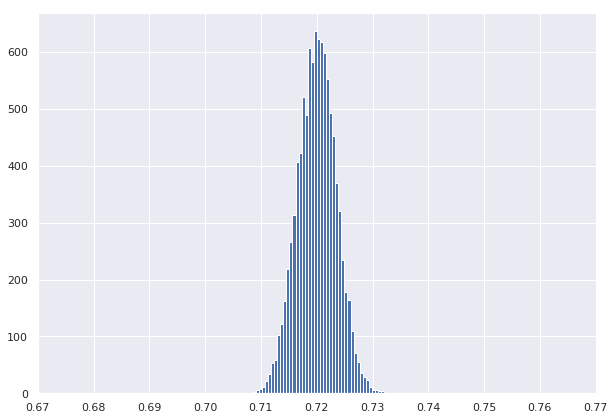

<Figure size 504x504 with 0 Axes>

In [69]:
plt.figure(figsize=(10,7))

plt.hist(bootstrapped_scores, bins=50)
plt.xticks(np.arange(0.67, 0.78, step=0.01))
# plt.title('')
plt.show()

plt.savefig("/home/marlan/Desktop/confidence_structural.pdf", bbox_inches='tight', pad_inches=0.1)

In [57]:
sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# Computing the lower and upper bound of the 90% confidence interval
# You can change the bounds percentiles to 0.025 and 0.975 to get
# a 95% confidence interval instead.
confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
    confidence_lower, confidence_upper))


Confidence interval for the score: [0.713 - 0.727]
